In [1]:
import os, sys
import itertools

import numpy as np
import torch
import matplotlib as mpl
from matplotlib import pyplot as plt

from models.generator import Generator

In [2]:
CKPT_FILEPATH = './data/generator_e400.ckpt'
PARAMS_DICT = {
    'num_classes': 5,
    'latent_dim': 256,
    'image_size': 192,
    'base_channels_encoder3d': 32,
    'base_channels_encoder2d': 32,
    'base_channels_decoder': 64,
    'depth_window_size': 3,
    'level_ch_mult': [ 1, 2, 4, 4, 4 ],
    'temporal_reduction_ratio': [ 1, 1, 1, 1 ],
    'attn_fusion_resolutions': [ 48, 24, 12 ],
    'encoder2d_norm': 'batch_norm_2d',
    'encoder3d_norm': 'batch_norm_3d',
    'decoder2d_norm': 'cc_instance_norm_2d',
    'p_dropout_encoder': 0.0
}

state_dict = torch.load(CKPT_FILEPATH)
model = Generator(**PARAMS_DICT)
model.load_state_dict(state_dict)
model = model.cuda().eval()

In [3]:
SAMPLE_FILEPATH = './data/samples.npz'
datadict = dict(np.load(SAMPLE_FILEPATH, allow_pickle=True))
selected_frame = torch.from_numpy(datadict['selected_frame'])  # [B, C, H, W]
cine_volumes = torch.from_numpy(datadict['cine_volumes'])  # [B=5, C=1, T=20, D=3, H=192, W=192]

k_class_id_batch = torch.tensor([0, 1, 2, 3, 4], dtype=torch.int64).cuda()
cge_images = []
with torch.no_grad():
    for i in range(len(selected_frame)):
        args_batch = [
            torch.repeat_interleave(selected_frame[[i], ...], 5, 0).cuda(),  # [5, 1, H, W]
            torch.repeat_interleave(cine_volumes[[i], ...], 5, 0).cuda()  # [5, 1, T, D, H, W]
        ]
        cge_image, _ = model(*args_batch, class_id=k_class_id_batch)  # [5, 1, H, W]
        cge_images.append(cge_image)
cge_images = torch.stack(cge_images)  # [#sample, #contrast, C=1, H, W]

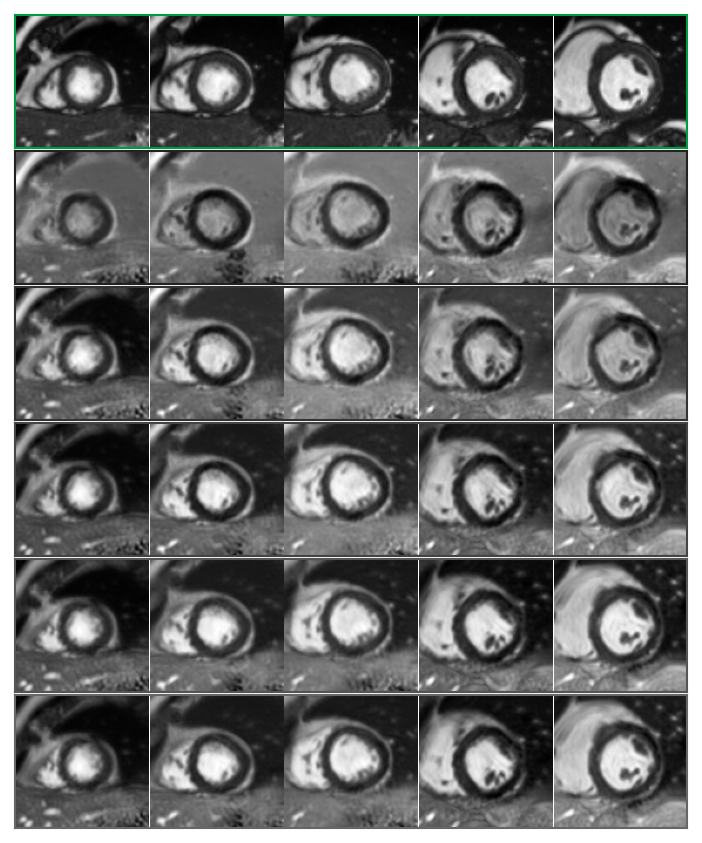

In [4]:
def create_axes(nrows, ncols, *, hgap_size: float=0.05, vgap_size: float=0.05, inch_per_image: float=1.0, boundary_size=0.0025, dpi=150):
    width_ratios = list(itertools.chain(*[(1, hgap_size) for _ in range(ncols - 1)])) + [1]
    height_ratios = list(itertools.chain(*[(1, vgap_size) for _ in range(nrows - 1)])) + [1]
    compensation_ratio = 1 / (1 - boundary_size)
    figsize = (inch_per_image * sum(width_ratios) *compensation_ratio, inch_per_image * sum(height_ratios) *compensation_ratio)
    fig = plt.figure(layout=None, figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(nrows=len(height_ratios), ncols=len(width_ratios), 
                          left=boundary_size, bottom=boundary_size, right=1-boundary_size, top=1-boundary_size, 
                          hspace=0, wspace=0, width_ratios=width_ratios, height_ratios=height_ratios)
    axes = np.zeros((nrows, ncols), dtype=object)
    for i in range(nrows):
        for j in range(ncols):
            axes[i, j] = gs[2 * i, 2 * j].subgridspec(1, 1, wspace=0.0, hspace=0).subplots()
    return fig, axes


def plot_images(axes, images, *, border_color=None, **kwargs4imshow):
    """
    :param axes: [n_slices,]
    :param images: [n_slices, H, W]
    """
    N = len(axes)
    assert N == len(images), f"#axes=={N} not compatible with images shape {images.shape}"
    for i, (ax, im) in enumerate(zip(axes, images)):
        ax.imshow(im, **kwargs4imshow)

        if border_color is None:
            ax.axis('off')
        else:
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            for loc, spine in ax.spines.items():
                if i == 0 and loc in {'left', 'bottom', 'top'} or \
                   i == (N-1) and loc in {'right', 'bottom', 'top'} or \
                   i >= 1 and i < (N-1) and loc in {'top', 'bottom'}:
                    spine.set(linewidth=1, color=border_color)
                else:
                    spine.set(linewidth=0, color=None)

def _crop_image(image, crop_ratio):
    if crop_ratio is not None:
        assert crop_ratio <= 1.0
        H, W = image.shape[-2:]
        cH, cW = H // 2, W // 2
        ws = int(min(H, W) * crop_ratio) // 2
        return image[..., cH - ws: cH + ws, cW - ws: cW + ws]
    else:
        return image
    

def fn_preprocess(x):
    x = _crop_image(x, crop_ratio=0.6)
    x = np.rot90(x, k=3, axes=(-2, -1))
    x = np.flip(x, axis=-1)
    return x


bssfp_images_np = selected_frame[:, 0, :, :].cpu().numpy()  # [D, H, W]
cge_images_np = cge_images[:, :, 0, :, :].cpu().numpy()  # [D, 5 Contrast, H, W]

fig, axes = create_axes(6, len(selected_frame), hgap_size=0.01, vgap_size=0.02, boundary_size=0.1)

KWARGS = {'cmap': 'gray'}
plot_images(axes[0, :], fn_preprocess(bssfp_images_np), border_color='#009944', **KWARGS)
plot_images(axes[1, :], fn_preprocess(cge_images_np[:, 0]), border_color='#222222', **KWARGS)
plot_images(axes[2, :], fn_preprocess(cge_images_np[:, 1]), border_color='#333333', **KWARGS)
plot_images(axes[3, :], fn_preprocess(cge_images_np[:, 2]), border_color='#444444', **KWARGS)
plot_images(axes[4, :], fn_preprocess(cge_images_np[:, 3]), border_color='#555555', **KWARGS)
plot_images(axes[5, :], fn_preprocess(cge_images_np[:, 4]), border_color='#666666', **KWARGS)

fig.show()